# Predictions and evaluation
* Load model, predict and store masks
* Compute IoU metric
* Visualize examples (high/low IoU per class; image + ground truth mask + prediction)

## Select which models to load (user input only required here)
Type in which model from the `saved_model` folder to load for which cell type. If the same model is used to predict the masks for each cell type, type in the same model name for all cell types.

In [1]:
mdl_astro  = "astro_U-net-from-scratch_steps_20_epochs_50" # User input: specify model here
mdl_cort   = "cort_U-net-from-scratch_steps_60_epochs_10" # User input: specify model here
mdl_shsy5y = "shsy5y_U-net-from-scratch_steps_24_epochs_25" # User input: specify model here

mdl_dict = {"astro": mdl_astro, "cort": mdl_cort, "shsy5y": mdl_shsy5y}

## Imports

In [2]:
import os
import pathlib
import shutil
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize
import image_modeling_import   # import image_modeling_import.py file

In [3]:
# Get the directory of the repository
curr_dir = os.getcwd()
parent_dir = pathlib.Path(curr_dir).parents[1]

preproc_path = f"{parent_dir}/data/data_preprocessed/"

## Specify folder name for predictions

## Predict, resize and store the masks based on the sliced images

In [4]:
# Read one example image to get original size
df = pd.read_csv("CSVs/cells_train_astro.csv", header = None)
img = imageio.imread(df.loc[0,0])
original_size = img.shape

In [5]:
for cell_type, model_name in mdl_dict.items():
        # Get image directories and model based on model selection above
        TRAIN_PATH = f"CSVs/cells_train_{cell_type}.csv"
        TEST_PATH  = f"CSVs/cells_test_{cell_type}.csv"
        EVAL_PATH  = f"CSVs/cells_eval_{cell_type}.csv"
        img_paths  = [TRAIN_PATH, EVAL_PATH, TEST_PATH]
        
        trained_model = tf.keras.models.load_model(f'saved_model/{model_name}')
        
        for path in img_paths:
            # Load images as tensorflow dataset
            dataset = image_modeling_import.load_dataset_seg(path, 10, training=False)
            
            # Load metadata to get image ID
            df = pd.read_csv(path, header = None)
            df["id"] = df.apply(lambda x: x.iloc[0].split("/")[-1].split(".")[0], axis = 1)
            
            # Predict masks and convert predictions in single channel numpy arrays that can be visualized as image
            predictions = trained_model.predict(dataset)
            predictions = tf.argmax(predictions, axis=-1)
            predictions = predictions[..., tf.newaxis]
            predictions = predictions.numpy()
            predictions = predictions
            
            # Resize and store
            for i, pred in enumerate(predictions):
                pred_resized = resize(pred, original_size, anti_aliasing = False, preserve_range = True).astype(dtype = np.uint8)
                imageio.imwrite(f"{preproc_path}sliced_images/predictions/masks/{df['id'][i]}_pred.png", pred_resized)
        

2022-02-24 13:59:36.240503: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-24 13:59:36.240595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


2022-02-24 13:59:39.074573: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-24 13:59:39.185980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 13:59:58.189401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 14:00:24.696625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## Recombine sliced predictions

In [6]:
# Since we already made the per-cell-type-model predictions
# and the train/test/eval split is identical for all-cell-types models and per-cell-type models,
# we can use the csv files that are not additionally split per cell type here.
TRAIN_PATH = 'CSVs/cells_train.csv'
EVAL_PATH  = 'CSVs/cells_eval.csv'
TEST_PATH  = 'CSVs/cells_test.csv'

In [7]:
# Instantiate lists that are filled with the desired output dataframe values (concatenate df after the loop below)
img_id = list()
data_subset = list()
IoU = list()

img_paths = {"train": TRAIN_PATH, "eval": EVAL_PATH, "test": TEST_PATH}


for ds, path in img_paths.items():
    # Load metadata to get image ID
    df = pd.read_csv(path, header = None)
    df["id"] = df.apply(lambda x: x.iloc[0].split("/")[-1].split(".")[0], axis = 1)
    
    # ID without slicing suffix
    id_combined_list = df["id"].apply(lambda x: x.split("_")[0]).unique().tolist()
    
    for id_comb in id_combined_list:
        
        # Recombine the sliced masks
        img_a = imageio.imread(f"{preproc_path}sliced_images/predictions/masks/{id_comb}_a_pred.png")
        img_b = imageio.imread(f"{preproc_path}sliced_images/predictions/masks/{id_comb}_b_pred.png")
        img_c = imageio.imread(f"{preproc_path}sliced_images/predictions/masks/{id_comb}_c_pred.png")
        img_d = imageio.imread(f"{preproc_path}sliced_images/predictions/masks/{id_comb}_d_pred.png")
        
        img_left  = np.concatenate((img_a, img_c))
        img_right = np.concatenate((img_b, img_d))
        
        mask_pred = np.concatenate((img_left, img_right), axis = 1).astype(dtype = np.uint8)
        
        imageio.imwrite(preproc_path + "mask_predicted/masks/" + id_comb + "_pred.png", mask_pred)
        
        # Compute and store intersections, unions, and IoU compared to original masks
        # mask_true = imageio.imread(preproc_path + "mask_groundtruth/" + id_comb + "_mask.png") # use original masks
        mask_true = imageio.imread(preproc_path + "masks_used_for_model/" + id_comb + "_mask.png") # use masks specified in 04_unet_data_pipeline
        
        intersection = ((mask_pred!=0) & (mask_true!=0)).astype(dtype = np.uint8)
        union        = ((mask_pred!=0) | (mask_true!=0)).astype(dtype = np.uint8)
        
        imageio.imwrite(preproc_path + "mask_predicted/intersections/" + id_comb + "_inter.png", intersection)
        imageio.imwrite(preproc_path + "mask_predicted/unions/" + id_comb + "_union.png", union)
        
        
        IoU.append(np.sum(intersection)/np.sum(union))
        
        img_id.append(id_comb)
        data_subset.append(ds)
        

        
df_IoU = pd.DataFrame({"dataset": data_subset, "id": img_id, "IoU": IoU})

In [8]:
df_IoU = pd.DataFrame({"dataset": data_subset, "id": img_id, "IoU": IoU})
df_IoU.head(10)

,dataset,id,IoU
0,train,0030fd0e6378,0.489949
1,train,0140b3c8f445,0.767580
2,train,01ae5a43a2ab,0.471414
3,train,026b3c2c4b32,0.500682
4,train,029e5b3b89c7,0.516699
5,train,0323e81d23d9,0.507889
6,train,042c17cd9143,0.524282
7,train,042dc0e561a4,0.476665
8,train,04928f0866b0,0.545935
9,train,049f02e0f764,0.298421


In [9]:
# Match the cell type and store 
df = pd.read_csv(f"{parent_dir}/data/data_original/train.csv") # Original train.csv from Kaggle
df.drop_duplicates(subset = ["id"], inplace = True)

df_IoU = df_IoU.merge(df[["id","cell_type"]], on = "id", how = "left")

df_IoU.to_csv("IoU.csv", index = False)

df_IoU.head(10)

,dataset,id,IoU,cell_type
0,train,0030fd0e6378,0.489949,shsy5y
1,train,0140b3c8f445,0.767580,astro
2,train,01ae5a43a2ab,0.471414,cort
3,train,026b3c2c4b32,0.500682,cort
4,train,029e5b3b89c7,0.516699,cort
5,train,0323e81d23d9,0.507889,cort
6,train,042c17cd9143,0.524282,shsy5y
7,train,042dc0e561a4,0.476665,shsy5y
8,train,04928f0866b0,0.545935,cort
9,train,049f02e0f764,0.298421,cort


In [10]:
df_IoU.to_csv("IoU.csv", index = False)

## Copy predictions to new, model-specific folder
...to avoid overwriting with predictions of different model

### Folder name based on model type, number of epochs, number of steps per epoch

In [11]:
if mdl_dict["astro"]==mdl_dict["shsy5y"]==mdl_dict["cort"]:
    n_steps  = int(mdl_dict["astro"].split("_")[3])

    n_epochs = mdl_dict["astro"].split("_")[-1]
    n_epochs = n_epochs.split("+")
    n_epochs = str(np.sum([int(ep) for ep in n_epochs]))
    
    pred_folder_name = mdl_dict["astro"].split("_")[1]
    pred_folder_name = f"{pred_folder_name}_allS{n_steps}E{n_epochs}"
    
else:
    pred_folder_name = mdl_dict["astro"].split("_")[1]
    
    for celltype, model in mdl_dict.items():
        
        n_steps = model.split("_")[-3]
        
        n_epochs = model.split("_")[-1]
        n_epochs = n_epochs.split("+")
        n_epochs = str(np.sum([int(ep) for ep in n_epochs]))
        
        cell_name = celltype
        cell_name = "".join([cell_name, 'S'])
        cell_name = "".join([cell_name, n_steps])
        cell_name = "".join([cell_name, 'E'])
        cell_name = "".join([cell_name, n_epochs])
        
        pred_folder_name = "_".join([pred_folder_name, cell_name])
    
print(pred_folder_name)

U-net-from-scratch_astroS20E50_cortS60E10_shsy5yS24E25


### Copy predicted masks, intersections and unions in new folder

In [12]:
for folder in ["intersections", "masks", "unions"]:
    
    dir_source = f"{preproc_path}mask_predicted/{folder}"
    dir_target = f"{preproc_path}mask_predicted/{pred_folder_name}/{folder}"

    shutil.copytree(dir_source, dir_target, dirs_exist_ok=True)

### Copy IoU.csv in new, model-specific folder

In [13]:
source = "IoU.csv"
dir_target = f"{preproc_path}mask_predicted/{pred_folder_name}"

shutil.copy(source, dir_target)

'/Users/philipp/neuefische/WHAT-THE-CELL...-AND-WHERE-/data/data_preprocessed/mask_predicted/U-net-from-scratch_astroS20E50_cortS60E10_shsy5yS24E25/IoU.csv'

## Check with example images

In [14]:
img_id = df_IoU["id"].sample(n=1).values[0]
img_id

'b03de5cbebb2'

In [15]:
img_id = "0140b3c8f445"

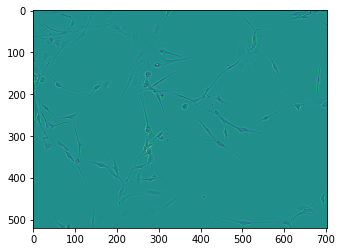

In [16]:
img = imageio.imread(f"{parent_dir}/data/data_original/train/{img_id}.png")
plt.imshow(img)

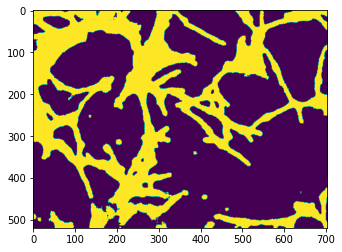

In [17]:
msk = imageio.imread(preproc_path + "masks_used_for_model/{}_mask.png".format(img_id))
plt.imshow(msk)

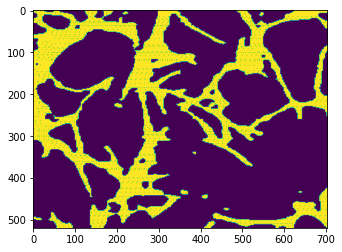

In [18]:
prd = imageio.imread(f"{preproc_path}/mask_predicted/masks/{img_id}_pred.png")
plt.imshow(prd)

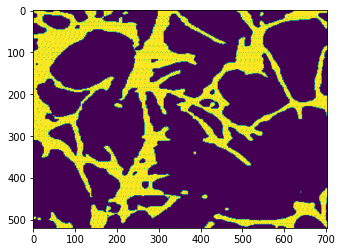

In [19]:
isn = imageio.imread(f"{preproc_path}/mask_predicted/intersections/{img_id}_inter.png")
plt.imshow(isn)

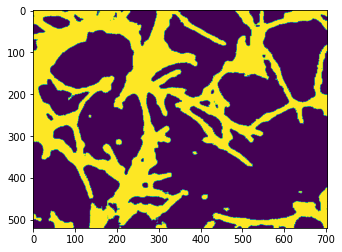

In [20]:
uni = imageio.imread(f"{preproc_path}/mask_predicted/unions/{img_id}_union.png")
plt.imshow(uni)